# Project 2 - Introduction to Image & Video Processing
##### Diogo Rio, i6265026 - Spring 2022

### Task 1 - Image Degradation w/ Motion Blur and Additive Noise
#### (1.1) Blur and Noise Application
##### 1. Motion Blur Function Creation + Application (Frequency Domain)

In [2]:
# Import required libraries and packages
from matplotlib import pyplot as plt
import numpy as np
import cv2

# NOTE: In some instances, I'll be using numpy to allow for better readability in simple computations.
# I assumed functions such as np.add(), np.multiply(), np.exp(), etc. don't count as non-allowed inbuilt functions.

# Function: Hide the output label(s)
def hide_labels(axis):
    for i in range(len(axis)):
        axis[i].plot()

# Function: Perform the desired plot build (2 images side to side)
def build_plot(img1, str1, img2, str2, gray):
    
    # Plot and set titles, avoiding warning by using casting to np.uint8
    fig, ax = plt.subplots(1, 2, figsize=(12,12))
    if gray:
        ax[0].imshow(img1, cmap = 'gray')
    else:
        ax[0].imshow(img1)
    ax[0].set_title(str1)
    if gray:
        ax[1].imshow(img2, cmap = 'gray')
    else:
        ax[1].imshow(img2, cmap = 'gray')
    ax[1].set_title(str2)
    hide_labels(ax)
    
# Function: Motion Blur Filtering, H(u,v)
def motion_blur(img, a, b):
    new_img = img.copy()
    
    # In order to keep image dimensions: 
    # Get row (x) and column (y) information from inputted image, f(x,y) 
    # since it will be the one transformed (and outputed)
    x = new_img.shape[0]
    y = new_img.shape[1]
    
    # Compute the two terms of H, as seen in Lab5
    # Using np.mgrid to fit dimensions to assign during the IFT process
    [u, v] = np.mgrid[-x/2:x/2, -y/2:y/2]
    u, v = 2*u/x, 2*v/y
    
    sinc_input = np.add(np.multiply(a, u), np.multiply(b, v)) 
    exp_input = np.multiply(-1j*np.pi, sinc_input)
    
    # Compute H(u,v)
    h = np.multiply(np.sinc(sinc_input), np.exp(exp_input))
        
    # Deconstruct the image so we can perform blur computations
    # Perform a 2D (D)FT, F(u,v)  
    ft_2d = np.fft.fft2(new_img)
    
    # Invert the FT performed, so we can obtain the image back, after applying filter h
    ift_2d = ft_2d.copy()
    # Build color channels
    ift_2d[:,:,0] = np.multiply(ft_2d[:,:,0], h) 
    ift_2d[:,:,1] = np.multiply(ft_2d[:,:,1], h) 
    ift_2d[:,:,2] = np.multiply(ft_2d[:,:,2], h) 
    
    new_img = np.fft.ifft2(ift_2d)
    
    return new_img

# Load image and transform it into its RGB format, so it can be used by the plotting functions
bird_img = cv2.imread('sample_imgs/bird.jpg')
bird_img = cv2.cvtColor(bird_img, cv2.COLOR_BGR2RGB)

# Apply motion blur
blur_img = motion_blur(bird_img, 0, 0.175)

##### 2. Additive Gaussian Noise Application on Motion Blurred Image (Fourier Domain)
(Noise should be noticeable, but not completely degrading of the image)

In [3]:
from skimage.util import random_noise

# Function: Additive Gaussian Noise, N(u,v)
def add_noise(img):
    new_img = img.copy()
    
    # From inbuilt function presented in Lab5:
    # In this case, it's simple, since rand_ns already adds over the provided image, forming G(u,v)
    new_img = random_noise(np.abs(new_img).astype(np.uint8), "gaussian", mean = 0, var = 0.25)
    
    return new_img

# Build final noisy image, G(u,v) = F(u,v) * H(u,v) + N(u,v)
# Apply noise addition to already blurred image
ns_blur_img = add_noise(blur_img)

##### 3. Display (1) and (2)

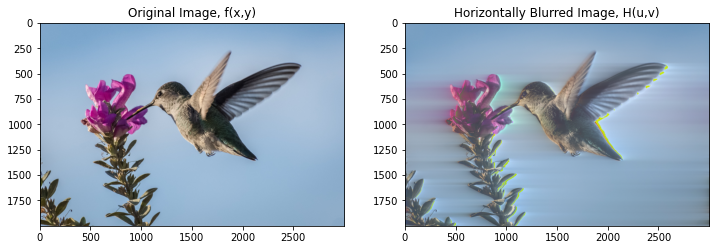

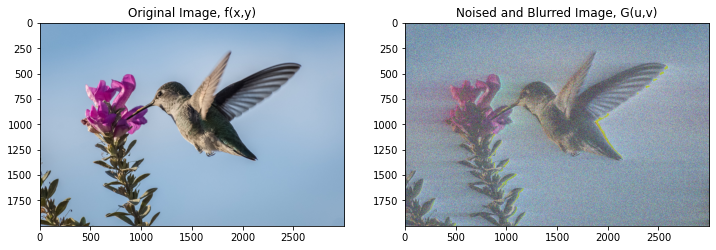

In [4]:
# Display results 
build_plot(bird_img, "Original Image, f(x,y)", np.abs(blur_img).astype(np.uint8), "Horizontally Blurred Image, H(u,v)", False)
build_plot(bird_img, "Original Image, f(x,y)", ns_blur_img, "Noised and Blurred Image, G(u,v)", False)

#### (1.2) Noise Removal
##### 1. Direct Inverse Filtering on Motion Blurred Image
(Display and explain results)

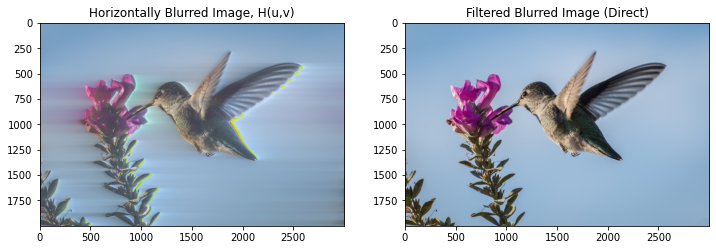

In [5]:
# Function: Direct Inverse Filtering of the Motion Blur
def blur_inv_filter(img, a, b):
    new_img = img.copy()
    
    # Same process altogether as explained before, yet divide to filter out, instead of multiplying by h
    x = new_img.shape[0]
    y = new_img.shape[1]

    [u, v] = np.mgrid[-x/2:x/2, -y/2:y/2]
    u, v = 2*u/x, 2*v/y
    
    sinc_input = np.add(np.multiply(a, u), np.multiply(b, v)) 
    exp_input = np.multiply(-1j*np.pi, sinc_input)

    h = np.multiply(np.sinc(sinc_input), np.exp(exp_input))
        
    ft_2d = np.fft.fft2(new_img)
    
    # Filtering out the known blur
    ift_2d = ft_2d.copy()
    ift_2d[:,:,0] = np.divide(ft_2d[:,:,0], h) 
    ift_2d[:,:,1] = np.divide(ft_2d[:,:,1], h) 
    ift_2d[:,:,2] = np.divide(ft_2d[:,:,2], h)
    
    new_img = np.fft.ifft2(ift_2d)
    
    return new_img

# Apply direct inverse filter to the motion blurred image
filt_blur_img = blur_inv_filter(blur_img, 0, 0.175)

# Display results 
build_plot(np.abs(blur_img).astype(np.uint8), "Horizontally Blurred Image, H(u,v)", 
           np.abs(filt_blur_img).astype(np.uint8), "Filtered Blurred Image (Direct)", False)

As we can see, the **direct inverse filtering** process is quite self-explanatory, as we can perform the computation of the blur we added to the image previously, all over again, and apply it to the blurred version of it. 

By applying it, it's understood that, since our goal is to filter out the blur, what is happening is that dividing each channel by H will result in the image we initially passed to get blurred on.

##### 2. Direct Inverse Filtering on Motion Blurred and Added Noise Image
(Display and explain results)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


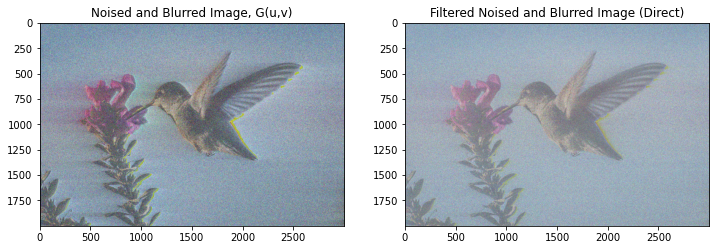

In [6]:
# Apply direct inverse filter to the motion blurred image
filt_ns_blur_img = blur_inv_filter(ns_blur_img, 0, 0.175)

# Display results 
build_plot(ns_blur_img, "Noised and Blurred Image, G(u,v)", 
           np.abs(filt_ns_blur_img), "Filtered Noised and Blurred Image (Direct)", False)

The same that was explained in the previous point applies here. The random noise is not being removed, since that noise cannot be known, thus it wouldn't be a direct inverse filter if we tried to remove that too. Thus, I understood it was to leave it in this demonstration.

The Gaussian noise seems to affect the blur noise removal of H, though it is possible to have been due to the constant conversions in number types. In any case, the effect of the filter is noticeable.

##### 3. MMSE Filter Equation on Added Noise Creation + Application on Added Noise Image
(Display and explain results)

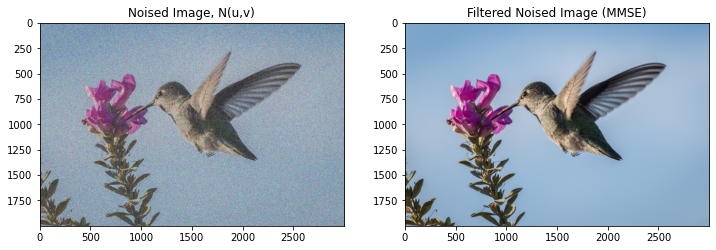

In [7]:
# Function: MMSE Filtering
def mmse_filter(img1, img2):
    og_img = img1.copy()
    ns_img = img2.copy()
    #ns_img = np.subtract(img2, og_img) # Noise
    
    # Assess the untouched image and the noise power
    og_ft_2d = np.fft.fft2(og_img)
    og_pwr = np.power(np.abs(og_ft_2d), 2)
    
    ns_ft_2d = np.fft.fft2(ns_img)
    ns_pwr = np.power(np.abs(ns_ft_2d), 2)
    
    #ft_2d = np.fft.fft2(np.add(og_pwr, ns_pwr))
    ft_2d = np.fft.fft2(np.subtract(og_img, ns_img))
    
    # Form the filtered image
    ift_2d = ft_2d.copy()
    #ift_2d = np.divide(ft_2d, np.add(1, (np.divide(ns_pwr, og_pwr))))
    # Build color channels
    ift_2d[:,:,0] = np.divide(ft_2d[:,:,0], np.add(1, (np.divide(ns_pwr, og_pwr)))[:,:,0])
    ift_2d[:,:,1] = np.divide(ft_2d[:,:,1], np.add(1, (np.divide(ns_pwr, og_pwr)))[:,:,1])
    ift_2d[:,:,2] = np.divide(ft_2d[:,:,2], np.add(1, (np.divide(ns_pwr, og_pwr)))[:,:,2]) 
    
    new_img = np.fft.ifft2(ift_2d)
    
    return new_img

# Only add noise to original image
ns_img = add_noise(bird_img)

# Apply MMSE Filter on added noise image np.abs(filt_ns_img).astype(np.uint8)
filt_ns_img = mmse_filter(bird_img, ns_img)

# Display results
build_plot(ns_img, "Noised Image, N(u,v)", np.abs(filt_ns_img).astype(np.uint8), "Filtered Noised Image (MMSE)", False)

The resulting filtered image shows

##### 4. MMSE Filter Equation on Motion Blur and Added Noise Creation + Noise Power Spectrum Ratio to OG Image Power Spectrum Approximation (using K) + K Computation (AVG of True Ratio) + Application on Motion Blurred and Added Noise Image
(Display and explain results)

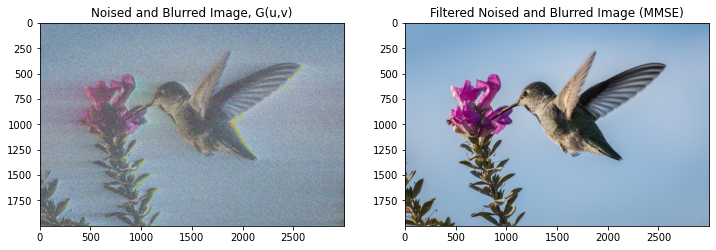

In [8]:
# Function: MMSE Filtering using the K Constant
def mmse_blur_filter(img1, img2):
    og_img = img1.copy()
    ns_img = img2.copy()
    
    #  k = np.sum(n_pwr_spectrum) / np.sum(o_pwr_spectrum)
    
    new_img = og_img
    
    return new_img

# Apply MMSE Filter on blurred and added noise image
#filt_ns_blur_img = mmse_blur_filter(bird_img, ns_blur_img)
filt_ns_blur_img = mmse_filter(bird_img, ns_blur_img)

# Display results
build_plot(ns_blur_img, "Noised and Blurred Image, G(u,v)", 
           np.abs(filt_ns_blur_img).astype(np.uint8), "Filtered Noised and Blurred Image (MMSE)", False)

### Task 2 - Image DCT Secret Message Hiding
#### (2.1) Watermark Insertion

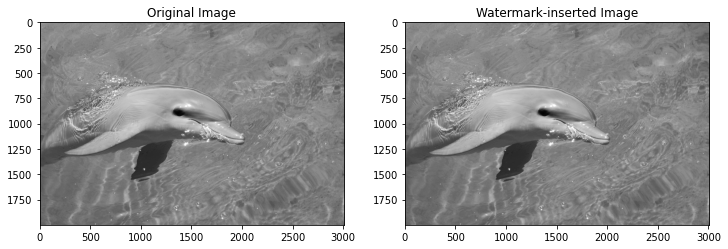

In [9]:
# Load image and transform it into its gray format, so it can satisfy the requirement
dolphin_img = cv2.imread('sample_imgs/dolphin.jpg')
dolphin_img = cv2.cvtColor(dolphin_img, cv2.COLOR_BGR2GRAY)

# Display images
build_plot(dolphin_img, "Original Image", dolphin_img, "Watermark-inserted Image", True)

#### (2.2) Watermark Detection

### Task 3 - Morphology
#### (3.1) Orange Counting

ORANGE COUNT
The orange image portrays 24 oranges.
The orange tree image portrays 64 oranges.


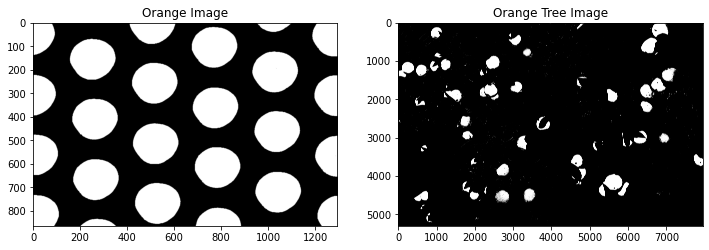

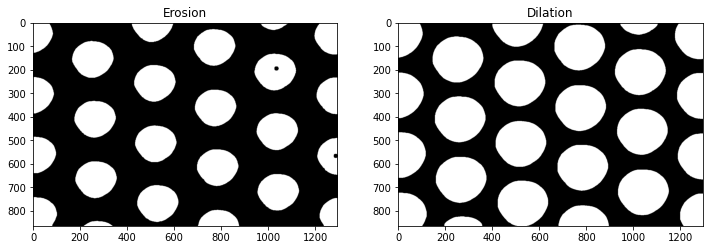

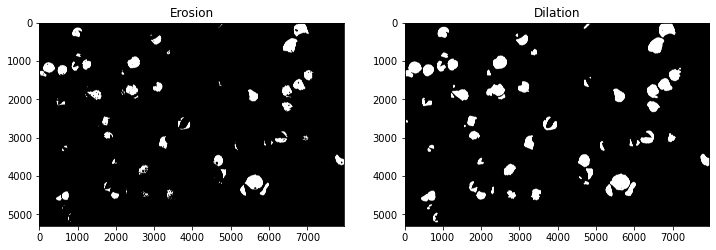

In [16]:
# Function: Isolate oranges in white, the rest blacks out
def convert_bw(img):
    
    new_img = img.copy()
    
    # The same threshold seemed to yield successful isolations in both images 
    # Thus, no need to pass it as a parameter
    th = 200 
    
    # 'Binarize' the image, turn all the values below the threshold to 255, the rest to 0
    res, new_img = cv2.threshold(new_img, th, 255, cv2.THRESH_BINARY)

    # Since orange is mostly present in the red channel,
    # assigning the 'binarized' R channel to G and B
    # resulted in a natural 3D-RGB black and white image
    new_img[:,:,1] = new_img[:,:,0]
    new_img[:,:,2] = new_img[:,:,0]
    
    return new_img

# Function: Transform an image to improve the counting process' effectiveness, using built-in morphological operations
def transform_img(img):
    
    new_img = img.copy()
    
    # Create the kernels (elliptical shape, to expand circularly) 
    kernel_e = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (18, 18))
    kernel_d = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (40, 40))
    
    # Erode and dilate image, mirroring the opening process - simulating noise removal
    img_e = cv2.erode(new_img, kernel_e)
    img_d = cv2.dilate(img_e, kernel_d)
    
    build_plot(img_e, "Erosion", img_d, "Dilation", False)
    
    return img_d

# Function: Count the number of circular shaped objects in a given image
def count_oranges(img, is_tree):
    
    new_img = img.copy()
    
    # Improve image by opening it
    new_img = transform_img(new_img)
    
    # Recalled from project 1
    # Finds and groups the deliminations of each circular line, the length of which will be the approximate nr. of oranges
    # (this works only in grayscale, so converting first)
    gray_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    count, res = cv2.findContours(gray_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Attempt at detecting connected components manually - forced server to restart, so better left commented out
    #loop_count, seen = 0, np.zeros((len(gray_img[:,0]), len(gray_img[0,:])))
    #for i in range(0, len(gray_img[:,0])):
    #    for j in range(0, len(gray_img[0,:])):
    #        if gray_img[i,j] == 255 and seen[i,j] == 0:
    #            # Increase the count, if a new unseen 255-pixel component was detected
    #            loop_count += 1
    #            seen = check(gray_img, seen, i, j)
    #            seen[i,j] = 1
    #nr_oranges = loop_count
                                
    nr_oranges = len(count)
    
    # Display result
    if is_tree:
        print("The orange tree image portrays", nr_oranges, "oranges.")
    else: 
        print("The orange image portrays", nr_oranges, "oranges.")

# Function: Detect connected components manually, recursively
def check(gray_img, seen, i, j):
    # Traverse adjacent pixels with value 255 and mark if connected to previous ones
    # This would be done until no more adjacent 255-pixels existed and all pixels were seen
    if (i+1) < len(gray_img[:,0]) and (i-1) >= 0 and (j+1) < len(gray_img[0,:]) and (j-1) >= 0:
        if gray_img[i+1,j] == 255 and seen[i+1,j] == 0:
            seen = check(gray_img, seen, i+1, j)
            seen[i+1,j] = 1
        if gray_img[i-1,j] == 255 and seen[i-1,j] == 0:
            seen = check(gray_img, seen, i-1, j)
            seen[i-1,j] = 1
        if gray_img[i,j+1] == 255 and seen[i,j+1] == 0:
            seen = check(gray_img, seen, i, j+1)
            seen[i,j+1] = 1
        if gray_img[i,j-1] == 255 and seen[i,j-1] == 0:
            seen = check(gray_img, seen, i, j-1)
            seen[i,j-1] = 1
            
    return seen
    
    
# Load images and transform them (to RGB, so to keep 3 dimensions as requested)
orange_img1 = cv2.imread('sample_oranges/oranges.jpg')
orange_img1 = cv2.cvtColor(orange_img1, cv2.COLOR_BGR2RGB)

orange_img2 = cv2.imread('sample_oranges/orangetree.jpg')
orange_img2 = cv2.cvtColor(orange_img2, cv2.COLOR_BGR2RGB)

# Manually convert them into black and white images
bw_orange_img1 = convert_bw(orange_img1)
bw_orange_img2 = convert_bw(orange_img2)

# Display images
build_plot(bw_orange_img1, "Orange Image", bw_orange_img2, "Orange Tree Image", False)

# Count and display each image's amount of oranges
print("ORANGE COUNT")
count_oranges(bw_orange_img1, False)
count_oranges(bw_orange_img2, True)

Naturally, the algorithm depends on detecting **color-based limits**, so one same orange intercepted by a leaf will count as two. Similarly, two oranges closely placed together may count as one, at times. Moreover, clear leaves due to natural or artificial lighting may have not been filtered out during the threshold binary stage, which could mean an addition of an unwanted orange to the image count.

Apart from that, following the process commented throughout the code snippet, we can see it was able to figure out where to morphologically count an orange (circle). The **opening** was able to filter out some of the unwanted noise, yet not all, as the **threshold** and the **kernel dimensions** can combine in many different ways to obtain different results.

#### (3.2) Granulometry

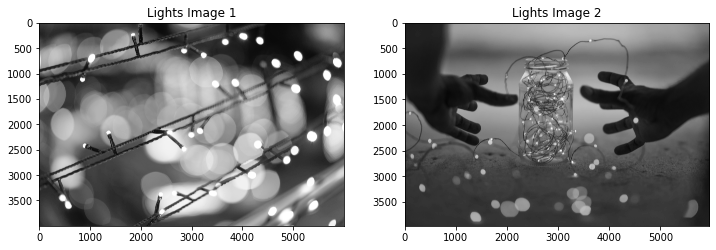

In [19]:
# Function: Compute frequency of image lights
def find_freq(img):
    new_img = img.copy()
    
    return new_img

# Load images and transform them (to grayscale, as requested)
light_img1 = cv2.imread('sample_imgs/lights.jpg')
light_img1 = cv2.cvtColor(light_img1, cv2.COLOR_BGR2GRAY)

light_img2 = cv2.imread('sample_imgs/jar.jpg')
light_img2 = cv2.cvtColor(light_img2, cv2.COLOR_BGR2GRAY)

# Display images
build_plot(light_img1, "Lights Image 1", light_img2, "Lights Image 2", True)

### Task 4 - PCA Recognition (on equally sized images)
(Choose 3 images and create N variations (atl. 5) for each)

Variation examples: noise addition, illumination/contrast varying, third-party face section alterations...

##### 1. Eigenface Finding using N variations (SbS Explanation)
(Show and explain appearance)

##### 2. Face Reconstruction using All Eigenfaces and 2 (approx.) Eigenfaces
(Display and explain results)

##### 3. Face Reconstruction using a Different Face's Eigenfaces (w/ the same Eigenvalues)
(Display and explain results)